### 1. Introducción.

Para este proyecto se ha empleado una base de datos que contiene información sobre ventas de videojuegos en diferentes partes del mundo, así como información intrínseca de cada uno (título, año, desarrollador, etc) para productos con más de 100.000 ventas a nivel global hasta el año 2020. La base de datos está compuesta por aproximadamente 16.600 documentos, cada uno correspondiente a un videojuego, con la información siguiente: 
- Name: título del videojuego.
- Platform: plataformas en las que está disponible (PlayStation 4, Nintendo DS, etc).
- Year: año de salida del producto.
- Genre: género.
- Publisher: empresa distribuidora (en millones).
- NA\_Sales: ventas en Norteamérica (en millones).
- EU\_Sales: ventas en Europa.
- JP\_Sales: ventas en Japón.
- Other\_Sales: ventas en el resto del mundo.
- Global\_Sales: ventas totales en el mundo.

Donde todos los datos numéricos de ventas están en millones ($10^6 $).

El objetivo de esta práctica es trabajar sobre esta base de datos haciendo consultas mediante filtros y agregaciones con MongoDB. Para ello se va a emplear Python con la librería *pymongo* en una hoja de *Jupyter Notebook*.

La creación de la base de datos y la importación de los mismos se ha llevado a cabo mediante *MongoDB Compass* a partir de un archivo .csv. Esta base de datos fue creada mediante *Web Scrapping* con la librería `BeautifulSoup` desde la web de VGChartz, una página de estadísticas sobre videojuegos.

In [2]:
## Esta celda incluye únicamente las librerías de funciones empleadas y la creación de la tabla (colección) usada.

import matplotlib.pyplot as plt
import plotly as pl
import seaborn as sb
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import collections


from pymongo import MongoClient
cliente = MongoClient("mongodb://localhost:27017/")
bbdd = cliente["TareaBBDDNoSQL"]
tabla = bbdd["Videojuegos"]

### 2. Funciones.

A continuación se encuentran algunas funciones que se han empleado en el análisis de los datos de la colección. El uso de estas funciones simplifica las consultas y ahorra tiempo en llevarlas a cabo.

In [2]:
def filter_collection(collection, filter, proyection = {}, limit = True):
    """
    Devuelve una consulta NoSQl sobre la tabla "collection", con el filtro "filter" y la proyección "proyection".

    Args:
        collection (pymongo.synchronous.collection.Collection): tabla de una BBDD NoSQL.
        filter (dict): filtro de la consulta.
        proyection (dict, opcional): proyección de la consulta. Por defecto es {}.
        limit (bool, opcional): trunca la salida. Por defecto es True.
    """
    
    # Se cuentan los documentos para saber cuántos han sido filtrados:
    print("Número de documentos obtenidos: ", collection.count_documents(filter), "\n")

    if limit:
        limit_n = 5
    else:
        limit_n = limit
    
    # Se aplican el filtro y la proyección y se obtienen los documentos:
    for doc in collection.find(filter, proyection).limit(limit_n):
        print(doc)

    if limit == True and collection.count_documents(filter) > 24:
        print("...")
        ultimos = list(tabla.find(filter, proyection).sort('_id', -1).limit(limit_n))
        for doc in reversed(ultimos):
            print(doc)
    return

La función `filter_collection()` recibe como argumentos la colección sobre la que se quiere hacer la consulta, el filtro y una proyección (esta última opcional), y devuelve todos los documentos de dicha colección que cumplen el filtro y bajo las condiciones de la proyección (como por ejemplo, no enseñar el campo `"_id"`). Esto se hace con el método `.find()`. Además, imprime por pantalla el número de documentos obtenidos y, por otro lado, incluye un argumento opcional llamado `limit` en forma de `bool`, que se toma por defecto como `True` y trunca la salida para mostrar sólo los 5 primeros documentos y los 5 últimos (esto evita que se muestren todos los documentos al pasar este archivo a formato .pdf, que es un fallo común en editores de texto a la hora de exportar).

### 3. Vista general de la base de datos.
En primer lugar, se hace una consulta con un `.find()` sin filtro pero indicando que no muestre el campo `_id` con una proyección, de forma que se puede hacer una vista general de los datos. Para ello se puede utilizar la función filter que se ha desarrollado anteriormente.

In [3]:
filtro = {}
proy = {"_id": 0}
filter_collection(tabla, filtro, proy)

Número de documentos obtenidos:  16601 

{'Name': 'Wii Sports', 'Platform': 'Wii', 'Year': 2006, 'Genre': 'Sports', 'Publisher': 'Nintendo', 'NA_Sales': 41.49, 'EU_Sales': 29.02, 'JP_Sales': 3.77, 'Other_Sales': 8.46, 'Global_Sales': 82.74}
{'Name': 'Super Mario Bros.', 'Platform': 'NES', 'Year': 1985, 'Genre': 'Platform', 'Publisher': 'Nintendo', 'NA_Sales': 29.08, 'EU_Sales': 3.58, 'JP_Sales': 6.81, 'Other_Sales': 0.77, 'Global_Sales': 40.24}
{'Name': 'Mario Kart Wii', 'Platform': 'Wii', 'Year': 2008, 'Genre': 'Racing', 'Publisher': 'Nintendo', 'NA_Sales': 15.85, 'EU_Sales': 12.88, 'JP_Sales': 3.79, 'Other_Sales': 3.31, 'Global_Sales': 35.82}
{'Name': 'Wii Sports Resort', 'Platform': 'Wii', 'Year': 2009, 'Genre': 'Sports', 'Publisher': 'Nintendo', 'NA_Sales': 15.75, 'EU_Sales': 11.01, 'JP_Sales': 3.28, 'Other_Sales': 2.96, 'Global_Sales': 33}
{'Name': 'Pokemon Red/Pokemon Blue', 'Platform': 'GB', 'Year': 1996, 'Genre': 'Role-Playing', 'Publisher': 'Nintendo', 'NA_Sales': 11.27, 'EU_S

Se puede ver que cada documento es un diccionario de Python (una clase de variables interna) y que además contienen los campos mencionados (Name, Platform, etc.)

Ahora se quiere comprobar el año más reciente para el cual se tienen documentos, así como el más temprano.

In [15]:
filtro = {"Year": {"$type": "int"}}

minimo = tabla.find(filtro).sort("Year", 1).limit(1)
min_year = next(minimo, {}).get("Year", None)
print(f"Año menos reciente: {min_year}")


maximo = tabla.find(filtro).sort("Year", -1).limit(1)
max_year = next(maximo, {}).get("Year", None)
print(f"Año más reciente: {max_year}")

Año menos reciente: 1980
Año más reciente: 2020


Para ello ha sido necesario un filtro que ignore los valores que no son numéricos, ya que hay algunos documentos para los que el campò "Year" es "N/A".

Y, por ejemplo, el año con más videojuegos que alcanzaron las 100.000 ventas es:

In [49]:
filtro_valido = {"Year": {"$type": "int"}}

years = [doc["Year"] for doc in tabla.find(filtro_valido, {"Year": 1})]
year_counts = collections.Counter(years)


año_max, max_count = year_counts.most_common(1)[0]
print(f"Año con más videojuegos: {año_max} | Cantidad: {max_count}")

Año con más videojuegos: 2009 | Cantidad: 1431


### 4. Filtros y consultas.

A continuación se va a filtrar por plataforma, para ver cuáles son los juegos más existosos para la PS2 y PS4, y que sólo se muestren la información propia del juego (título, año, etc.) y las ventas globales. Además, sólo se quieren los juegos con más de un millón de ventas, que es el umbral para el que un juego AAA (o de alto presupuesto) se considera exitoso en la industria.

In [18]:
filtro = {
    "Platform": {"$in": ["PS2", "PS4"]},
    "Global_Sales": {"$gte": 1}
    }
proy = {
    "_id": 0,
    "NA_Sales": 0,
    "EU_Sales": 0,
    "JP_Sales": 0,
    "Other_Sales": 0
}

filter_collection(tabla, filtro, proy)

Número de documentos obtenidos:  398 

{'Name': 'Grand Theft Auto: San Andreas', 'Platform': 'PS2', 'Year': 2004, 'Genre': 'Action', 'Publisher': 'Take-Two Interactive', 'Global_Sales': 20.81}
{'Name': 'Grand Theft Auto: Vice City', 'Platform': 'PS2', 'Year': 2002, 'Genre': 'Action', 'Publisher': 'Take-Two Interactive', 'Global_Sales': 16.15}
{'Name': 'Gran Turismo 3: A-Spec', 'Platform': 'PS2', 'Year': 2001, 'Genre': 'Racing', 'Publisher': 'Sony Computer Entertainment', 'Global_Sales': 14.98}
{'Name': 'Call of Duty: Black Ops 3', 'Platform': 'PS4', 'Year': 2015, 'Genre': 'Shooter', 'Publisher': 'Activision', 'Global_Sales': 14.24}
{'Name': 'Grand Theft Auto III', 'Platform': 'PS2', 'Year': 2001, 'Genre': 'Action', 'Publisher': 'Take-Two Interactive', 'Global_Sales': 13.1}
...
{'Name': 'Rayman Legends', 'Platform': 'PS4', 'Year': 2014, 'Genre': 'Platform', 'Publisher': 'Ubisoft', 'Global_Sales': 1.01}
{'Name': 'Ford Racing 2', 'Platform': 'PS2', 'Year': 2003, 'Genre': 'Racing', 'Publis

Si se representan los datos en un gráfico circular se puede ver que la mayoría de juegos para estas dos consolas son de "Shooter" y "Action" (que son realmente lo mismo) o "Sports" y "Racing" (que también se pueden incluir en la misma categoría).

In [19]:
datos = list(tabla.find(filtro, proy))
genres = [game["Genre"] for game in datos]
sales = [game["Global_Sales"] for game in datos]
data = pd.DataFrame({'Géneros': genres, 'Ventas totales': sales})

fig = go.Figure(data=[go.Pie(
    labels = data["Géneros"],        
    values = data["Ventas totales"], 
    textinfo = "percent",            
    textposition = "inside",         
    hoverinfo = "label+value"        
)])

fig.update_layout(
    title="Porcentaje de Ventas Globales por Publisher",
    showlegend = True
)


fig.update_layout(
    title = {
        "text": "Porcentaje de Ventas Globales por género",
        "x": 0.55,
        "y": 0.9,
        "xanchor": "center",
        "yanchor": "top"
    },
    legend = {
        "yanchor": "middle",
        "y": 0.5,           
        "xanchor": "left",  
        "x": 0.65           
    }
)

fig.show()

Ahora se piden únicamente los juegos de la plataforma "PS3" que sean de género "Action".

In [20]:
filtro = {"Platform": "PS3",
          "Genre": "Action"}
# Aprovechando la proyección definida en la celda anterior:
filter_collection(tabla, filtro, proy)

Número de documentos obtenidos:  380 

{'Name': 'Grand Theft Auto V', 'Platform': 'PS3', 'Year': 2013, 'Genre': 'Action', 'Publisher': 'Take-Two Interactive', 'Global_Sales': 21.4}
{'Name': 'Grand Theft Auto IV', 'Platform': 'PS3', 'Year': 2008, 'Genre': 'Action', 'Publisher': 'Take-Two Interactive', 'Global_Sales': 10.57}
{'Name': 'FIFA Soccer 13', 'Platform': 'PS3', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 8.24}
{'Name': "Uncharted 3: Drake's Deception", 'Platform': 'PS3', 'Year': 2011, 'Genre': 'Action', 'Publisher': 'Sony Computer Entertainment', 'Global_Sales': 6.83}
{'Name': 'Uncharted 2: Among Thieves', 'Platform': 'PS3', 'Year': 2009, 'Genre': 'Action', 'Publisher': 'Sony Computer Entertainment', 'Global_Sales': 6.73}
...
{'Name': 'Shin Sangoku Musou Online: Souten Ranbu', 'Platform': 'PS3', 'Year': 2010, 'Genre': 'Action', 'Publisher': 'Tecmo Koei', 'Global_Sales': 0.02}
{'Name': 'Barbie and Her Sisters Puppy Rescue', 'Platform': 'PS3', 

Se puede observar que el juego con título "FIFA Soccer 13" tiene asignado el género "Action" cuando es evidente que le corresponde "Sports", por lo que es necesario corregirlo con el método `.update_many()`. No se puede utilizar el método `.update_one()` porque hay varios documentos para ese título y con el mismo campo "Name" debido a la distinción entre plataformas. La actualización se hace de la siguiente manera:

In [21]:
filtro = {"Name": "FIFA Soccer 13"}
filter_collection(tabla, filtro, proy, limit = False)


print("\nColección actualizada:\n")

actualizacion = {"$set": {"Genre": "Sports"}}
tabla.update_many(filtro, actualizacion)
filtro = {"Name": "FIFA Soccer 13"}
filter_collection(tabla, filtro, proy, limit = False)

Número de documentos obtenidos:  8 

{'Name': 'FIFA Soccer 13', 'Platform': 'PS3', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 8.24}
{'Name': 'FIFA Soccer 13', 'Platform': 'X360', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 5.18}
{'Name': 'FIFA Soccer 13', 'Platform': 'Wii', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 0.72}
{'Name': 'FIFA Soccer 13', 'Platform': 'WiiU', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 0.48}
{'Name': 'FIFA Soccer 13', 'Platform': 'PSV', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 0.47}
{'Name': 'FIFA Soccer 13', 'Platform': 'PC', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 0.41}
{'Name': 'FIFA Soccer 13', 'Platform': 'PSP', 'Year': 2012, 'Genre': 'Action', 'Publisher': 'Electronic Arts', 'Global_Sales': 0.37}
{'Name': 'FIFA Soccer 13', 'Pla

Uno de los juegos más exitosos del año 2017 es Hollow Knight, pero no se encuentra en la base de datos. Mediante el método `.insert_one()` o `.insert_many()` (ya que según la estructura de los datos es necesario un documento por plataforma) es posible introducirlo con la siguiente información de ventas correspondiente:

In [26]:
filtro = {"Name": "Hollow Knight"}
filter_collection(tabla, filtro)


gameA = {'Name': 'Hollow Knight', 'Platform': 'PS4', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 2.01, 'EU_Sales': 0.84, 'JP_Sales': 1.2, 'Other_Sales': 1.7, 'Global_Sales': 5.75}
gameB = {'Name': 'Hollow Knight', 'Platform': 'XOne', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 0.97, 'EU_Sales': 0.5, 'JP_Sales': 0.3, 'Other_Sales': 1.14, 'Global_Sales': 2.91}
gameC = {'Name': 'Hollow Knight', 'Platform': 'PC', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 2.86, 'EU_Sales': 2.22, 'JP_Sales': 3.02, 'Other_Sales': 1.87, 'Global_Sales': 9.97}

tabla.insert_many([gameA, gameB, gameC])


print("\nColección actualizada:\n")
filtro = {"Name": "Hollow Knight"}
filter_collection(tabla, filtro)


Número de documentos obtenidos:  0 


Colección actualizada:

Número de documentos obtenidos:  3 

{'_id': ObjectId('6761d3916d2a9d871197c70e'), 'Name': 'Hollow Knight', 'Platform': 'PS4', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 2.01, 'EU_Sales': 0.84, 'JP_Sales': 1.2, 'Other_Sales': 1.7, 'Global_Sales': 5.75}
{'_id': ObjectId('6761d3916d2a9d871197c70f'), 'Name': 'Hollow Knight', 'Platform': 'XOne', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 0.97, 'EU_Sales': 0.5, 'JP_Sales': 0.3, 'Other_Sales': 1.14, 'Global_Sales': 2.91}
{'_id': ObjectId('6761d3916d2a9d871197c710'), 'Name': 'Hollow Knight', 'Platform': 'PC', 'Year': 2017, 'Genre': 'Platform', 'Publisher': 'Team Cherry', 'NA_Sales': 2.86, 'EU_Sales': 2.22, 'JP_Sales': 3.02, 'Other_Sales': 1.87, 'Global_Sales': 9.97}


### 5. Agrupaciones.

En esta sección se van a agrupar los datos en función de sus campos para poder analizarlos de manera más sencilla. El primer ejemplo será agruparlos por distribuidor ("Publisher") y comparar el total de ventas y de productos con `aggregate`.

In [4]:
steps = [
    {"$group": {
        "_id": "$Publisher",
        "total_sales": {"$sum": "$Global_Sales"},
        "total_games": {"$sum": 1}
    }},
    {"$sort": {"total_sales": -1}},
    ]

datos = list(tabla.aggregate(steps))

print(f"Número de distribuidores: {len(datos)}\n")
n = 0
for doc in datos:
    n += 1
    print(f"Publisher: {doc["_id"]} | Games: {doc["total_games"]} | Total Sales: {round(doc["total_sales"], 2)}")
    if n >= 20:
        print("...")
        break


Número de distribuidores: 580

Publisher: Nintendo | Games: 703 | Total Sales: 1786.56
Publisher: Electronic Arts | Games: 1351 | Total Sales: 1110.32
Publisher: Activision | Games: 975 | Total Sales: 727.46
Publisher: Sony Computer Entertainment | Games: 683 | Total Sales: 607.5
Publisher: Ubisoft | Games: 921 | Total Sales: 474.72
Publisher: Take-Two Interactive | Games: 413 | Total Sales: 399.54
Publisher: THQ | Games: 715 | Total Sales: 340.77
Publisher: Konami Digital Entertainment | Games: 832 | Total Sales: 283.64
Publisher: Sega | Games: 639 | Total Sales: 272.99
Publisher: Namco Bandai Games | Games: 932 | Total Sales: 254.09
Publisher: Microsoft Game Studios | Games: 189 | Total Sales: 245.79
Publisher: Capcom | Games: 381 | Total Sales: 200.89
Publisher: Atari | Games: 363 | Total Sales: 157.22
Publisher: Warner Bros. Interactive Entertainment | Games: 232 | Total Sales: 153.89
Publisher: Square Enix | Games: 233 | Total Sales: 145.18
Publisher: Disney Interactive Studios | 

Agrupar los datos con `.aggregate()` nos permite representarlos de forma sencilla para poder obtener conclusiones mediante un análisis rápido de los mismos. A partir de los siguientes gráficos se pueden sacar algunas conclusiones rápidas.

- En el primer gráfico se observa que, del total de ventas, tan sólo 8 distribuidores ocupan el 64.1% aproximadamente, dejando a las 572 empresas restantes con el 35.8%.
- En el segundo se puede observar que, aunque hay distribuidores con una cantidad de videojuegos publicados similar, sus ventas son muy distintas. Además, esto indica que un mayor número de videojuegos publicados no tiene por qué dar lugar a más ventas.
- El tercero es un gráfico de burbujas interactivo en el que se puede visualizar la comparación de ventas en función de los juegos publicados.

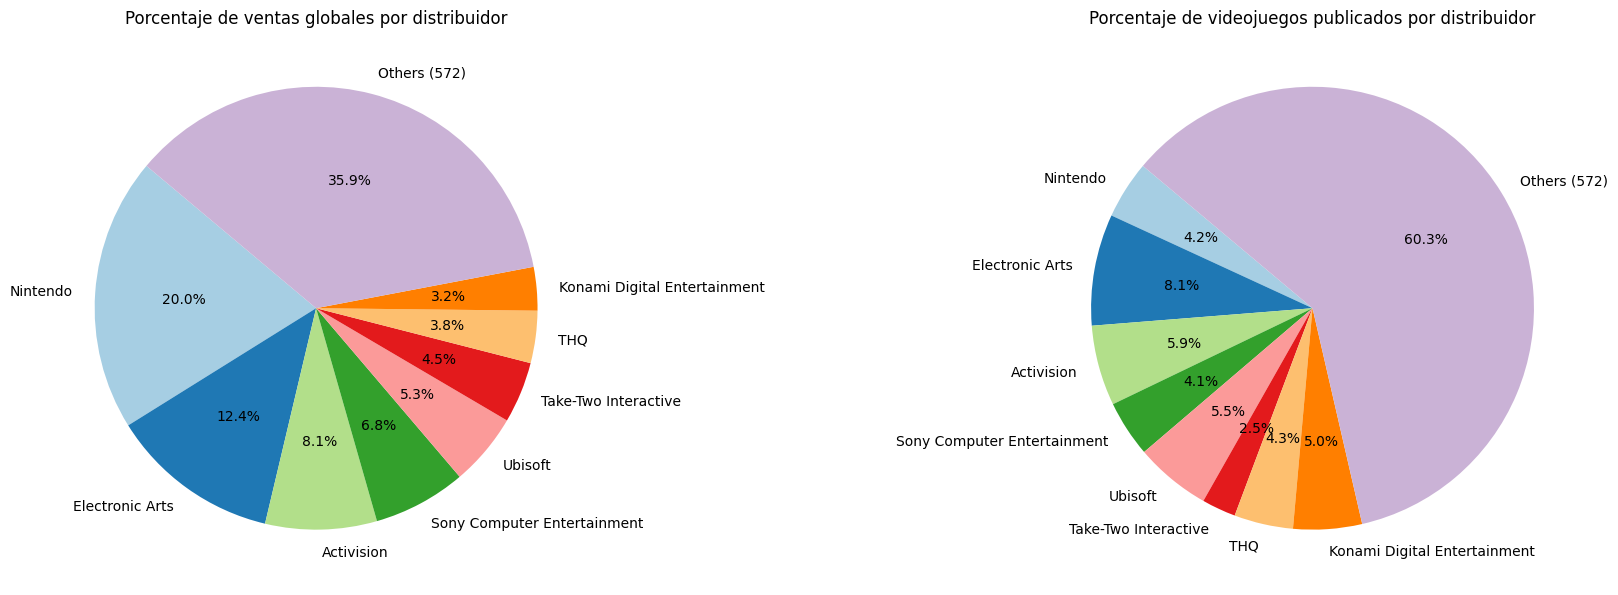

In [28]:
n = 8
publishers = [empresa["_id"] for empresa in datos]
publishers2 = publishers[:n]
publishers2.append(f"Others ({len(publishers)-len(publishers2)})")

sales = [empresa["total_sales"] for empresa in datos]
sales2 = sales[:n]
sales2.append(sum(sales[n:]))

games = [empresa["total_games"] for empresa in datos]
games2 = games[:n]
games2.append(sum(games[n:]))


fig, ax = plt.subplots(1, 2, figsize=(20, 20))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(1, 2, 1)
plt.pie(sales2, labels = publishers2, autopct = '%1.1f%%', startangle = 140, colors = plt.cm.Paired.colors)
plt.title('Porcentaje de ventas globales por distribuidor')

plt.subplot(1, 2, 2)
plt.pie(games2, labels = publishers2, autopct = '%1.1f%%', startangle = 140, colors = plt.cm.Paired.colors)
plt.title('Porcentaje de videojuegos publicados por distribuidor')
plt.show()

In [29]:
data = pd.DataFrame({'Distribuidor': publishers, 'Ventas totales': sales, "Videojuegos publicados": games})

fig = px.scatter(data, 
                 x = "Videojuegos publicados", 
                 y = "Ventas totales", 
                 size = "Ventas totales", 
                 color = "Distribuidor",
                 title = "Ventas globales en función de la cantidad de juegos publicados",
                 labels = {"Videojuegos publicados": "Juegos publicados", "Ventas totales": "Ventas globales"},
                 hover_name = "Distribuidor", 
                 size_max = 60)
fig.show()

Otra opción es agrupar en función de las pataformas para ver cuál es más exitosa. Esta agrupación se puede combinar con otra que sea por géneros para ver si la combinación de algún género con una plataforma concreta influye en las ventas.

Para esta consulta se va a agrupar por plataformas y por géneros, de forma que se obtiene cada plataforma y los géneros más vendidos en cada una en orden descendiente.

In [30]:
steps = [
    {"$group": {
        "_id": {"Platform": "$Platform", "Genre": "$Genre"},
        "total_sales": {"$sum": "$Global_Sales"},
        "total_games": {"$sum": 1},
    }},
    {"$group": {
        "_id": "$_id.Platform",
        "total_platform_sales": {"$sum": "$total_sales"},
        "Genre": {
            "$push": {
                "Genre": "$_id.Genre",
                "total_sales": "$total_sales",
            }
        }
    }},
    
    {"$addFields": {
        "Genre": {"$sortArray": {"input": "$Genre", "sortBy": {"total_sales": -1}}}
    }},
        
    {"$sort": {"total_platform_sales": -1}},
    ]

datos = list(tabla.aggregate(steps))

print(f"Número de plataformas: {len(datos)}\n")
n = 0
for doc in datos:
    print(f"Plataforma: {doc["_id"]}")
    n += 1
    for genre_data in doc["Genre"]:
        print(f"    Genre: {genre_data["Genre"]} | Total Sales: {round(genre_data["total_sales"], 2)}")
        n += 1
    if n >= 15:
        print("    ...")
        break

Número de plataformas: 31

Plataforma: PS2
    Genre: Sports | Total Sales: 273.41
    Genre: Action | Total Sales: 272.76
    Genre: Racing | Total Sales: 156.28
    Genre: Shooter | Total Sales: 108.57
    Genre: Misc | Total Sales: 101.14
    Genre: Role-Playing | Total Sales: 93.5
    Genre: Fighting | Total Sales: 92.6
    Genre: Platform | Total Sales: 72.51
    Genre: Simulation | Total Sales: 42.66
    Genre: Adventure | Total Sales: 21.16
    Genre: Strategy | Total Sales: 15.15
    Genre: Puzzle | Total Sales: 5.9
Plataforma: X360
    Genre: Shooter | Total Sales: 278.55
    Genre: Action | Total Sales: 237.49
    Genre: Sports | Total Sales: 144.3
    Genre: Misc | Total Sales: 91.96
    Genre: Role-Playing | Total Sales: 71.98
    Genre: Racing | Total Sales: 65.99
    Genre: Fighting | Total Sales: 37.64
    Genre: Adventure | Total Sales: 15.23
    Genre: Simulation | Total Sales: 14.45
    Genre: Platform | Total Sales: 11.39
    Genre: Strategy | Total Sales: 10.13
    

Como se puede comprobar, las plataformas con más juegos vendidos son PS2 y X360, y los géneros más populares son parecidos en ambas ("Action", "Shooter", "Sports", etc).

Otra agrupación que puede merecer la pena llevar a cabo sería una por regiones, de forma que se pueda observar qué tipo de juegos o qué empresas tienen más éxito en los distintos lugares del mundo según las ventas.

### 6. Conclusiones.

Como se puede comprobar, los juegos más exitosos pertenecen a aquellas empresas con mayor número de productos publicados y que estos siempre pertenecen a los géneros más populares.

Además, aunque los datos con los que se ha trabajado son suficientes para comparar las ventas de videojuegos, se podría hacer una comparación más profunda si se añadiese una columna de datos conteniendo el presupuesto de cada uno, ya que es un factor que influye enormemente en las ventas (por lo general).